<a href="https://colab.research.google.com/github/areebaxijaz/AER850-Project-3/blob/main/AER850Project3_100epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/ProjectthreeData/data'
data_yaml_path = f'{base_path}/data.yaml'

In [ ]:
!pip install opencv-python-headless ultralytics torch numpy pillow

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Step 1: Image Masking using OpenCV

# Load the motherboard image
image_path = '/content/computermotherboard.jpeg'  # Replace with image path
image = cv2.imread(image_path)

# Convert image to grayscale for thresholding
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1.1: Apply thresholding
# Thresholding separates the background from the PCB based on pixel intensity
_, thresholded_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

# Step 1.2: Edge Detection
# Using Canny edge detection to detect the edges of the PCB
edges = cv2.Canny(gray_image, 100, 200)

# Step 1.3: Contour Detection
# Find contours based on the edges detected
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Filter contours by area to remove small irrelevant ones
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]


In [ ]:
# Step 1.4: Creating a mask from the contours
# Create a blank mask with the same dimensions as the image

mask = np.zeros_like(gray_image)

# Draw contours on the mask to isolate the PCB
cv2.drawContours(mask, filtered_contours, -1, (255), 3)

# Step 1.5: Apply the mask to the original image to extract the PCB
pcb_extracted = cv2.bitwise_and(image, image, mask=mask)

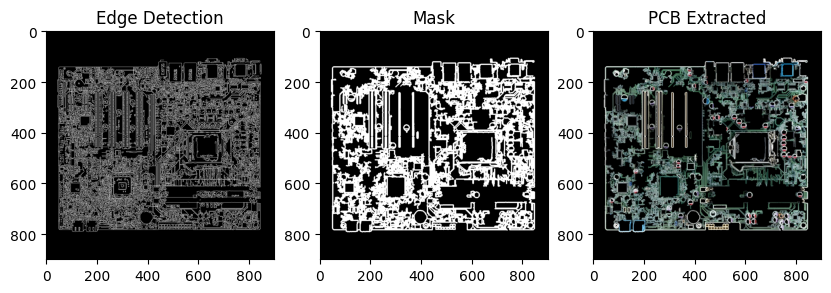

In [ ]:
# Display the masking results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
plt.title("Edge Detection")
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(pcb_extracted, cv2.COLOR_BGR2RGB))
plt.title("PCB Extracted")
plt.show()

In [ ]:
# Step 2: YOLOv8 Training with Google Colab GPU

# Load the YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')


100%|██████████| 6.25M/6.25M [00:00<00:00, 18.1MB/s]


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Training parameters
epochs = 100  # Number of training epochs
batch_size = 10  # Number of images per batch
image_size = 900  # Image size for training

# Training using data.yaml, which should define paths to train, val, test datasets
model.train(
    data=data_yaml_path,  # Path to data.yaml file in Google Drive
    epochs=epochs,
    batch=batch_size,
    imgsz=image_size,
    name='pcb_component_detection_model60'
)


NameError: name 'model' is not defined

In [ ]:
# Step 3: YOLOv8 Evaluation on Test Images

# Paths to test images for evaluation
test_image_paths = [
    f'{base_path}/evaluation/ardmega.jpg',
    f'{base_path}/evaluation/arduno.jpg',
    f'{base_path}/evaluation/rasppi.jpg'
]


image 1/1 /content/drive/MyDrive/ProjectthreeData/data/evaluation/ardmega.jpg: 832x928 1 Button, 6 Capacitors, 5 Connectors, 6 ICs, 2 Leds, 12 Resistors, 42.3ms
Speed: 6.6ms preprocess, 42.3ms inference, 1.7ms postprocess per image at shape (1, 3, 832, 928)


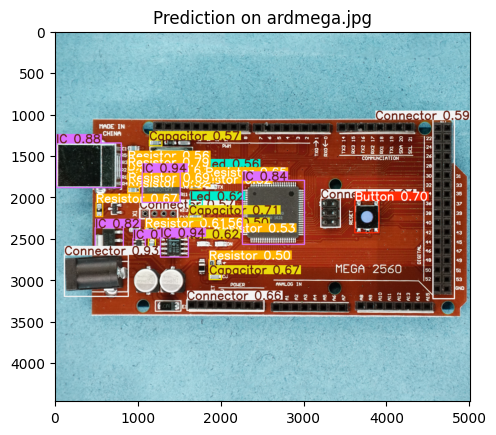


image 1/1 /content/drive/MyDrive/ProjectthreeData/data/evaluation/arduno.jpg: 640x928 11 Capacitors, 6 Connectors, 2 Electrolytic Capacitors, 2 ICs, 1 Led, 4 Resistors, 1 Transistor, 41.5ms
Speed: 4.1ms preprocess, 41.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 928)


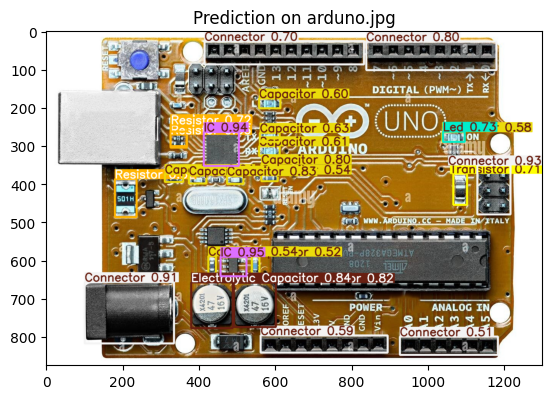


image 1/1 /content/drive/MyDrive/ProjectthreeData/data/evaluation/rasppi.jpg: 640x928 7 Capacitors, 9 Connectors, 1 Electrolytic Capacitor, 7 ICs, 1 Pads, 9 Resistors, 8.8ms
Speed: 5.3ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 928)


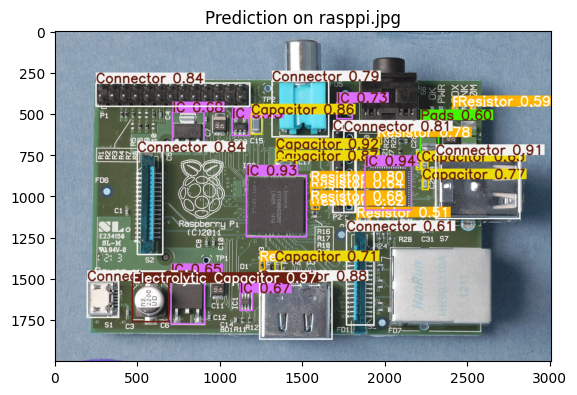

In [ ]:
# Evaluate each test image
for image_path in test_image_paths:
    results = model.predict(source=image_path, conf=0.5)  # Confidence threshold at 0.5

    # Display prediction results
    for result in results:
        plt.imshow(result.plot())  # Plot prediction results on the image
        plt.title(f"Prediction on {image_path.split('/')[-1]}")
        plt.show()